# To The Cloud (AND BEYOND)
Now that we have a good idea on how to solve the digit problem, it's time to move the training part to the cloud (again, there's no need to with this problem but for other problems we test locally to test things out on a subset of our data and move to the cloud to work on the whole lot).

Let's set some things up!

In [1]:
import json
import time
import azureml
from azureml.core.model import Model
from azureml.core import Workspace, Run, Experiment
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails
from torchvision import datasets, transforms

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


# Setting up Azure Machine Learning service
The first thing you need to do is create an Azure Machine Learning workspace. There are [docs](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started#create-a-workspace) on how to do that. If you're a command line type person, I have an [example](https://github.com/sethjuarez/workspacestarter) of how you can set it up using the Azure CLI. Once you've set the project up fill in the appropriate settings for your workspace by uncommenting the first the code to write out the config file. Once the config file has been written out, you can load the workspace programmatically like I've done below.

In [2]:
# use this code to set up config file
#subscription_id ='<SUB_ID>'
#resource_group ='<RESOURCE_GROUP>'
#workspace_name = '<WORKSPACE>'

#try:
#   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
#   ws.write_config()
#   print('Workspace configuration succeeded. You are all set!')
#except:
#   print('Workspace not found. TOO MANY ISSUES!!!')

# once you run the above code once, you can use the written config
ws = Workspace.from_config()

Found the config file in: C:\projects\pytorchintro\aml_config\config.json


# Cloud Compute
Next we need to define a compute target for your experiment. Since this is a brand new workspace, feel free to change the name of your cluster (I called my `racer`). The code below tries to get a reference to my cluster but if it doesn't exist, it creates it for me. If you're creating a cluster this might take a bit of time. Also, please turn these off when you're done (in fact consider setting the `min_nodes` to 0 so the cluster turns off automatically if it's idle for too long) - I don't want you to get an unexpected bill.

In [4]:
cluster = 'racer'
try:
    compute = ComputeTarget(workspace=ws, name=cluster)
    print('Found existing compute target "{}"'.format(cluster))
except ComputeTargetException:
    print('Creating new compute target "{}"...'.format(cluster))
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', min_nodes=1, max_nodes=6)
    compute = ComputeTarget.create(ws, cluster, compute_config)
    compute.wait_for_completion(show_output=True)

Found existing compute target "racer"


# Time to Experiment
Once our compute target has been set up it's time to package up our tiny notebook from last time into a single script that a remote compute environment can run. I've taken the time to [do that for you](train.py). In fact, if you look at the file you will see all of the exact same concepts we learned from the previous notebook (it's almost exactly the same but I have added additional things to make it easier to pass things into the script).

In AzureML service there is a concept of an experiment. For every experiment you can have multiple runs. In this case I'm using an `Estimator` object that defines how the experiment should run.

### Don't read this if you don't care what we do in the background
In the background the estimator is basically a definition of sorts for a docker image that will house your experiment. The best part about all of this is that irrespective of what you use for your experiment (a crazy custom version of TensorFlow or something) it should always run - it's a container after all. It's pretty slick.

### Back to the regular stuff
Once we submit our estimator to be run on AzureML service, it copies the contents of the current directory and packages them up to run in our new container (well, it will upload everything with the exception of anything you put describe in the [.amlignore](https://github.com/sethjuarez/pytorchintro/blob/master/.amlignore) file).

Notice also that since I'm using `argparse` I can specify external parameters to the trainin script as part of the estimator definition.

Let's run the next three lines to see what happens!

In [5]:
# Create and run experiment
mnist = Experiment(ws, 'pytorchmnist')

# script parameters
script_params={
    '--epochs': 15,
    '--batch': 100,
    '--lr': .001,
    '--model': 'cnn'
}

# Create Estimator
estimator = PyTorch(source_directory='.',
                       compute_target=compute, 
                       entry_script='train.py',
                       script_params=script_params,
                       use_gpu=True)

run = mnist.submit(estimator)

In [6]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
pytorchmnist,pytorchmnist_1545340099288,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [7]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

If everything wen't to plan you should see something like this:

![Digit Examples](images/run_widget.png)

Notice that indeed the loss function decreased (on average) over time and the accuracy of the model increased! Try playing around with the `learning_rate` by changing the parameters. Better yet, you can have [AzureML service sweep accross a whole bunch of parameters](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) for you!

Now for the question of how I got those wonderful charts to show up. This is where AzureML service starts to actually add value to what you were already doing. With a [few](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L156-L166) [strategically](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L121-L122) [placed](https://github.com/sethjuarez/pytorchintro/blob/master/train.py#L142-L143) log statements AzureML service was able to create this output. In fact, if a value is logged more than once it automatically creates charts instead of items in a table.

# The Model
Once the training is all done and you're satisfied with the output, you can actually peruse the ouput of all of the runs for a given experiment and promote it to an "official" workspace model. This is an awesome feature because the important files (i.e. the model that will make us zillionaires) are usually sitting on the computer some dude named Jeff. Also, many people don't even version models nowadays - running the code below will!

In [8]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/80_driver_log.txt',
 'outputs/model.pth',
 'outputs/model.onnx',
 'driver_log',
 'azureml-logs/azureml.log',
 'azureml-logs/55_batchai_execution.txt']

In [9]:
model_file = 'outputs/model.pth'
run.download_file(name=model_file, output_file_path='model.pth')
model = Model.register(ws, model_name='PyTorchMNIST', model_path='model.pth', 
                       description='CNN PyTorch Model')

Registering model PyTorchMNIST


# The Image
Now that we have the model, if we want to use it in production we need to define how one should use the model. This is sometimes called scoring or inferencing. For AzureML service we are basically looking for two functions:
1. `init()`, and
2. `run(raw)` which takes in a json string and returns a prediction
First thing's first though - we need to describe the environment where the scoring script will live and package it up into an environment file.

In [10]:
myenv = CondaDependencies()
myenv.add_pip_package('numpy')
myenv.add_pip_package('torch')
with open('pytorchmnist.yml','w') as f:
    print('Writing out {}'.format('pytorchmnist.yml'))
    f.write(myenv.serialize_to_string())
    print('Done!')

Writing out pytorchmnist.yml
Done!


Next we need to tell AzureML service the location of the scoring script. I have take the liberty, dear reader, to [create that for you](score.py). Looking through the file you should be able to easily find both the `init()` and `run(raw)` methods. You can also run the file locally to make sure it is doing the right thing.

Now that we have everything let's create an image!

### Don't read this if you don't want to know what is happening in the background
What we basically do is create a docker image from your definition and push it up to the an Azure Container Registry that belogns to the Workspace.

**NOTE** This takes a while

In [11]:
from azureml.core.image import ContainerImage, Image

# create image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                runtime="python", 
                                conda_file="pytorchmnist.yml")

image = Image.create(ws, 'pytorchmnist', [model], image_config)
image.wait_for_creation(show_output=True)

Creating image
Running.............................................
SucceededImage creation operation finished for image pytorchmnist:5, operation "Succeeded"


# Deploy!!
You could have certainly stopped with creating the image and moving the rest of the deployment process to something like Azure Pipelines. If you want to continue to deploy this service to the Workspace, this is how you do it.

In [12]:
from azureml.core.webservice import Webservice, AciWebservice

service_name = 'pytorchmnist-svc'

# check for existing service
svcs = [svc for svc in Webservice.list(ws) if svc.name==service_name]
if len(svcs) == 1:
    print('Deleting prior {} deployment'.format(service_name))
    svcs[0].delete()

# create service
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                            memory_gb=1, 
                                            description='simple MNIST digit detection')
service = Webservice.deploy_from_image(workspace=ws, 
                                    image=image, 
                                    name=service_name, 
                                    deployment_config=aciconfig)
service.wait_for_deployment(show_output=True)
print(service.scoring_uri)

Deleting prior pytorchmnist-svc deployment
Creating service
Running.........................
SucceededACI service creation operation finished, operation "Succeeded"


You have the option of pushing the image to ACI or even a workspace Kubernetes cluster.

Sometimes things go wrong....... If it does for you run the code below to see the actual [logs](deploy.log)!

In [106]:
with open('deploy.log','w') as f:
    f.write(service.get_logs())

# Running Service
IT'S ALIVE!!! Let's see if it does sensible things. We will load up the test data from before so we can try randome numbers.

In [14]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )
print(len(digits))

60000


You can basically choose any number as an index up to 60,000 (well, one less). Try out a couple to see how the service does!

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


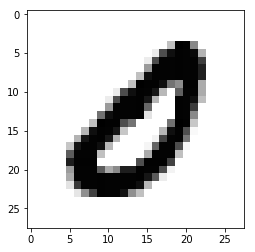

In [18]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

X, Y = digits[57435]
X = X * 255
plt.imshow(255 - X.reshape(28,28), cmap='gray')
print(Y)

In [16]:
# This is a string representation of the image we will POST to the endpoint
image_str = ','.join(map(str, X.int().tolist()))
print(image_str)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,246,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,252,252,193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,240,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,240,140,114,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,233,71,0,159,252,252,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,233,74,0,0,253,252,239,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,151,0,0,0,253,252,195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,141,240,252,252,252,253,27,0,0,0,253,252,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,178,140,0,0,0,0,141,255,2

In [17]:
import json
import requests
service_url = service.scoring_uri
print(service_url)
r = requests.post(service_url, json={'image': image_str })
r.json()

http://13.83.149.109:80/score


{'time': 0.104436,
 'prediction': 0,
 'scores': [0.995736837387085,
  2.3327098475078856e-08,
  0.003980344161391258,
  0.00016383796173613518,
  4.010713894331275e-08,
  5.167449853615835e-05,
  1.7358546756440774e-05,
  4.9987315833277535e-06,
  4.1949653677875176e-05,
  3.171517391820089e-06]}

# Final Thoughts
Hoepfully this little journey was helpful! My goal is to show you that tha basics of Machine Learning are not all that bad. If you have any comments, suggestions, or something does not make sense make sure to drop me a line!